 11%|█         | 110/1000 [00:01<00:15, 57.23it/s]

Episode 100/1000, Average Reward: 39.06


 20%|██        | 205/1000 [00:04<00:29, 26.89it/s]

Episode 200/1000, Average Reward: 83.69


 30%|███       | 301/1000 [00:09<00:37, 18.72it/s]

Episode 300/1000, Average Reward: 165.96


 40%|████      | 405/1000 [00:13<00:24, 23.93it/s]

Episode 400/1000, Average Reward: 139.06


 50%|█████     | 501/1000 [00:18<00:28, 17.31it/s]

Episode 500/1000, Average Reward: 110.15


 60%|██████    | 601/1000 [00:32<01:09,  5.75it/s]

Episode 600/1000, Average Reward: 334.17


 70%|███████   | 700/1000 [00:48<03:08,  1.60it/s]

Episode 700/1000, Average Reward: 487.12


 80%|████████  | 801/1000 [01:28<00:12, 15.77it/s]

Episode 800/1000, Average Reward: 1060.03


 90%|█████████ | 901/1000 [01:35<00:08, 11.81it/s]

Episode 900/1000, Average Reward: 152.27


100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]

Episode 1000/1000, Average Reward: 325.64


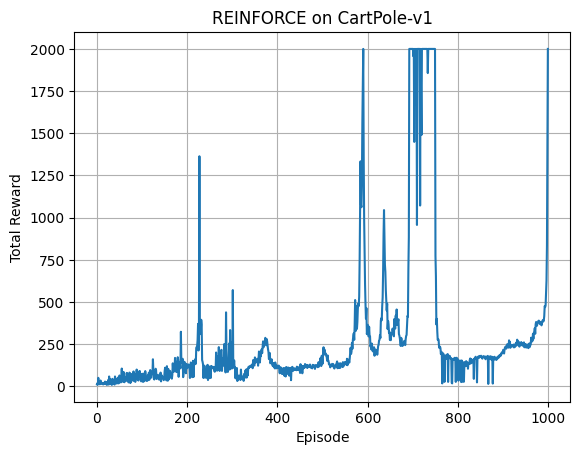

Evaluation Episode 1: Total Reward = 2000.0
Evaluation Episode 2: Total Reward = 2000.0
Evaluation Episode 3: Total Reward = 2000.0


In [9]:
# REINFORCE Policy Gradient on CartPole-v1

"""
CartPole is a classic control task where the objective is to prevent a pole from falling over by applying forces left or right on a moving cart. The problem is considered solved if the pole remains upright for 500 time steps.

This implementation trains a neural network policy using the REINFORCE algorithm (a Monte Carlo policy gradient method). A trained agent's performance demo is available [here](https://drive.google.com/file/d/17V9g7aonZ7jQCIGPqfW1xen8ug0WZh9K/view).
"""

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Environment
env = gym.make("CartPole-v1", render_mode=None)

# Policy Network Definition
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

# Compute discounted return
def compute_returns(rewards, gamma=0.99):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Training loop
def train(policy, optimizer, episodes=1000, gamma=0.99, max_steps=2000):
    reward_history = []
    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        log_probs, rewards = [], []

        done = False
        steps = 0
        while not done and steps < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()

            next_state, reward, done, truncated, _ = env.step(action.item())
            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            state = next_state
            steps += 1

        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        loss = -torch.stack(log_probs) @ returns

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(sum(rewards))

        if (episode + 1) % 100 == 0:
            avg = np.mean(reward_history[-100:])
            print(f"Episode {episode + 1}/{episodes}, Average Reward: {avg:.2f}")

    return reward_history

# Evaluate the trained agent visually
def evaluate(policy, episodes=5, max_steps=2000):
    eval_env = gym.make("CartPole-v1", render_mode="human")
    for ep in range(episodes):
        state, _ = eval_env.reset()
        total_reward = 0
        done = False
        steps = 0

        while not done and steps < max_steps:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32)
                probs = policy(state_tensor)
                action = torch.argmax(probs).item()

            state, reward, done, truncated, _ = eval_env.step(action)
            total_reward += reward
            _ = eval_env.render()
            steps += 1

        print(f"Evaluation Episode {ep+1}: Total Reward = {total_reward}")

    eval_env.close()

# Initialize policy and optimizer
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=5e-3)

# Train the agent
rewards = train(policy, optimizer, episodes=1000)

# Plot learning curve
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE on CartPole-v1')
plt.grid(True)
plt.show()

# Run evaluation
evaluate(policy, episodes=3)


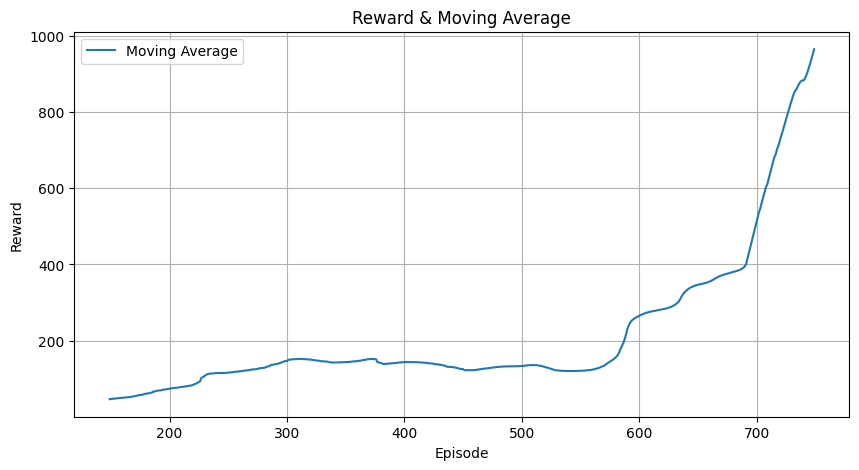

In [ ]:
# Compute moving average of rewards
def moving_average(data, window_size=150):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot total rewards and moving average
ma_rewards = moving_average(rewards[:750], window_size=150)

plt.figure(figsize=(10, 5))
plt.plot(range(150 - 1, len(rewards[:750])), ma_rewards, label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average')
plt.legend()
plt.grid(True)
plt.show()
